#Расчёт потока частиц в детектор. Учёт потенциала спутника

In [1]:
import numpy as np
import matplotlib.pyplot as plt

###Константы

In [2]:
U_sat_values = [0, 1, 2, 3, 4]
e = 1.60218e-19
m = 1.6726219e-27
k = 1.380649e-23
T = 5000
v_pl = 8000
gamma = 0
n = 1000
alpha = np.deg2rad(5)
v2 = 50000
mu_alpha = np.cos(alpha)

###Распределение Максвелла

In [3]:
def maxwell_distribution(v, v_pl, mu, gamma, phi, T):
    tmp = 4 * np.pi * v**2 * (m / (2 * np.pi * k * T))**1.5
    return tmp * np.exp(-m * (v**2 + v_pl**2 - 2*v*v_pl*(mu*np.cos(gamma) + np.sqrt(1-mu**2)*np.sin(gamma)*np.cos(phi))) / (2 * k * T))

###Метод Симпсона

In [4]:
def integrate_simpson(f, a, b, n):
    if n % 2 != 0:
        n += 1

    h = (b - a) / n

    integral = f(a) + f(b)

    for i in range(1, n):
        x_i = a + i * h

        if i % 2 == 0:
            integral += 2 * f(x_i)
        else:
            integral += 4 * f(x_i)

    return integral * h / 3

###Первый вариант: изменение пределов интегрирования

Если интегрировать функцию распределения до влияния электрического поля спутника, то необходимо изменить только пределы интегрирования по величине скорости и углу тета.

In [5]:
def integrand(v, v_pl, gamma, phi, mu, T, U_sat):
    kappa = e * U_sat / m
    v_min = np.sqrt(2 * kappa)
    if v < v_min:
        return 0  # Частицы не могут достичь детектора

    mu_min = min(mu_alpha, np.sqrt(2 * kappa) / v) if v > 0 else 1
    if mu < mu_min:
        return 0  # Частицы не могут достичь детектора

    return n * maxwell_distribution(v, v_pl, mu, gamma, phi, T) * v * mu

In [6]:
def calculate_flux(T, U_sat):
    num_intervals_v = 1000  # Количество интервалов для интегрирования по скорости
    num_intervals_mu = 1000  # Количество интервалов для интегрирования по углу
    num_intervals_phi = 1000  # Количество интервалов для интегрирования по фи

    v1 = np.sqrt(2 * (e * U_sat / m))

    # Интегрирование от v1 до v2
    flux_v = integrate_simpson(lambda v: integrand(v, v_pl, np.deg2rad(gamma), 1, 1, T, U_sat), v1, v2, num_intervals_v)

    # Интегрирование от mu_alpha до 1
    flux_mu = integrate_simpson(lambda mu: flux_v, mu_alpha, 1, num_intervals_mu)

    # Интегрирование от 0 до 2pi
    total_flux = integrate_simpson(lambda phi: flux_mu, 0, 2*np.pi, num_intervals_phi)
    return total_flux

In [7]:
def calculate_v0_mu0(v, mu, U_sat):
    kappa = e * U_sat / m
    v0 = np.sqrt(v**2 + 2 * kappa)
    denominator = v**2 + 2 * kappa
    if denominator == 0:
        denominator = 1e-10  # Добавляем небольшое значение, чтобы избежать деления на ноль
    mu0 = np.sqrt((v**2 * mu**2 + 2 * kappa) / denominator)
    return v0, mu0

###Второй вариант: изменить функцию распределения

Интегрировать «измененную» функцию распределения, после взаимодействия с космическим аппаратом. При этом изменится функция распределения, а пределы интегрирования – нет.

Потенциал спутника (В) | Ионный поток (первый вариант)
-----------------------|-------------------------------
          0            | 1755847.8432
          1            | 1197768.8587
          2            |  464441.1329
          3            |  134463.0929
          4            |   32749.0388

Потенциал спутника (В) | Ионный поток (второй вариант)
-----------------------|-------------------------------
          0            | 1755847.8432
          1            | 1197768.8627
          2            |  464441.1376
          3            |  134463.0977
          4            |   32749.0436


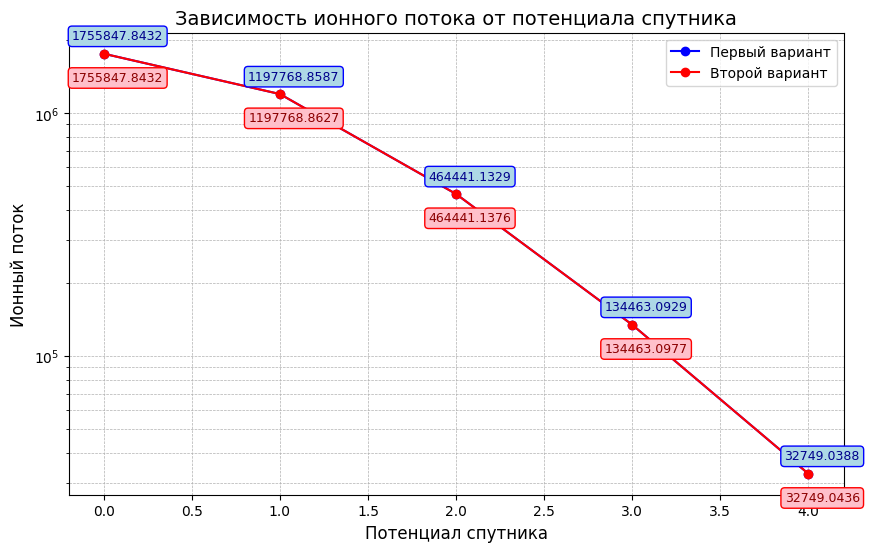

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры задачи
U_sat_values = [0, 1, 2, 3, 4]  # Потенциалы спутника в В
e = 1.60218e-19  # Заряд электрона в Кл
m = 1.6726219e-27  # Масса протона в кг
k = 1.380649e-23  # Постоянная Больцмана в Дж/К
T = 5000  # Температура в Кельвинах
v_pl = 8000  # Скорость плазмы (м/с)
gamma = 0  # Угол гамма
n = 1000  # Концентрация ионов
alpha = np.deg2rad(5)  # Угол раствора коллиматора в радианах
v2 = 50000  # Верхний предел скорости в м/с
mu_alpha = np.cos(alpha)

# Функция распределения Максвелла
def maxwell_distribution(v, v_pl, mu, gamma, phi, T):
    tmp = 4 * np.pi * v**2 * (m / (2 * np.pi * k * T))**1.5
    return tmp * np.exp(-m * (v**2 + v_pl**2 - 2*v*v_pl*(mu*np.cos(gamma) + np.sqrt(1-mu**2)*np.sin(gamma)*np.cos(phi))) / (2 * k * T))

# Численное интегрирование методом Симпсона
def integrate_simpson(f, a, b, num_intervals):
    if num_intervals % 2 != 0:
        num_intervals += 1  # Метод Симпсона требует четного числа интервалов
    dx = (b - a) / num_intervals
    integral = f(a) + f(b)
    for i in range(1, num_intervals):
        x = a + i * dx
        if i % 2 == 0:
            integral += 2 * f(x)
        else:
            integral += 4 * f(x)
    integral *= dx / 3
    return integral

# Подынтегральная функция для потока частиц (первый вариант)
def integrand(v, v_pl, gamma, phi, mu, T, U_sat):
    kappa = e * U_sat / m
    v_min = np.sqrt(2 * kappa)
    if v < v_min:
        return 0  # Частицы не могут достичь детектора

    mu_min = min(mu_alpha, np.sqrt(2 * kappa) / v) if v > 0 else 1
    if mu < mu_min:
        return 0  # Частицы не могут достичь детектора

    return n * maxwell_distribution(v, v_pl, mu, gamma, phi, T) * v * mu

# Функция для вычисления потока (первый вариант)
def calculate_flux(T, U_sat):
    num_intervals_v = 1000  # Количество интервалов для интегрирования по скорости
    num_intervals_mu = 1000  # Количество интервалов для интегрирования по углу
    num_intervals_phi = 1000  # Количество интервалов для интегрирования по фи

    v1 = np.sqrt(2 * (e * U_sat / m))

    # Интегрирование от v1 до v2
    flux_v = integrate_simpson(lambda v: integrand(v, v_pl, np.deg2rad(gamma), 1, 1, T, U_sat), v1, v2, num_intervals_v)

    # Интегрирование от mu_alpha до 1
    flux_mu = integrate_simpson(lambda mu: flux_v, mu_alpha, 1, num_intervals_mu)

    # Интегрирование от 0 до 2pi
    total_flux = integrate_simpson(lambda phi: flux_mu, 0, 2*np.pi, num_intervals_phi)
    return total_flux

# Функция для вычисления v0 и mu0
def calculate_v0_mu0(v, mu, U_sat):
    kappa = e * U_sat / m
    v0 = np.sqrt(v**2 + 2 * kappa)
    denominator = v**2 + 2 * kappa
    if denominator == 0:
        denominator = 1e-10  # Добавляем небольшое значение, чтобы избежать деления на ноль
    mu0 = np.sqrt((v**2 * mu**2 + 2 * kappa) / denominator)
    return v0, mu0

# Подынтегральная функция для потока частиц (второй вариант)
def integrand_v2(v, v_pl, gamma, phi, mu, T, U_sat):
    v0, mu0 = calculate_v0_mu0(v, mu, U_sat)

    # Функция распределения Максвелла с учетом v0 и mu0
    tmp = 4 * np.pi * v0**2 * (m / (2 * np.pi * k * T))**1.5
    f = tmp * np.exp(-m * (v0**2 + v_pl**2 - 2*v0*v_pl*(mu0*np.cos(gamma) + np.sqrt(1-mu0**2)*np.sin(gamma)*np.cos(phi))) / (2 * k * T))

    return n * f * v * mu

# Функция для вычисления потока (второй вариант)
def calculate_flux_v2(T, U_sat):
    num_intervals_v = 1000  # Количество интервалов для интегрирования по скорости
    num_intervals_mu = 1000  # Количество интервалов для интегрирования по углу
    num_intervals_phi = 1000  # Количество интервалов для интегрирования по фи

    # Интегрирование от 0 до v2
    flux_v = integrate_simpson(lambda v: integrand_v2(v, v_pl, np.deg2rad(gamma), 1, 1, T, U_sat), 0, v2, num_intervals_v)

    # Интегрирование от mu_alpha до 1
    flux_mu = integrate_simpson(lambda mu: flux_v, mu_alpha, 1, num_intervals_mu)

    # Интегрирование от 0 до 2pi
    total_flux = integrate_simpson(lambda phi: flux_mu, 0, 2*np.pi, num_intervals_phi)
    return total_flux

# Расчет потока для каждого потенциала (первый вариант)
results = {}
for U_sat in U_sat_values:
    results[U_sat] = calculate_flux(T, U_sat)

# Построение таблицы для первого варианта
print("Потенциал спутника (В) | Ионный поток (первый вариант)")
print("-----------------------|-------------------------------")
for U_sat, flux in results.items():
    if flux < 100000:
        print(f"{U_sat:^21}  |   {flux:.4f}")
    elif flux < 1000000:
        print(f"{U_sat:^21}  |  {flux:.4f}")
    else:
        print(f"{U_sat:^21}  | {flux:.4f}")

# Расчет потока для каждого потенциала (второй вариант)
results_v2 = {}
for U_sat in U_sat_values:
    results_v2[U_sat] = calculate_flux_v2(T, U_sat)

# Построение таблицы для второго варианта
print("\nПотенциал спутника (В) | Ионный поток (второй вариант)")
print("-----------------------|-------------------------------")
for U_sat, flux in results_v2.items():
    if flux < 100000:
        print(f"{U_sat:^21}  |   {flux:.4f}")
    elif flux < 1000000:
        print(f"{U_sat:^21}  |  {flux:.4f}")
    else:
        print(f"{U_sat:^21}  | {flux:.4f}")

# Построение графика зависимости потока от потенциала спутника (оба варианта на одном графике)
plt.figure(figsize=(10, 6))

# Первый вариант
plt.plot(U_sat_values, list(results.values()), marker='o', linestyle='-', color='b', label='Первый вариант')

# Второй вариант
plt.plot(U_sat_values, list(results_v2.values()), marker='o', linestyle='-', color='r', label='Второй вариант')

# Добавление аннотаций для первого варианта
for i, (U_sat, flux) in enumerate(results.items()):
    plt.annotate(f"{flux:.4f}", (U_sat, flux), textcoords="offset points", xytext=(10, 10), ha='center', fontsize=9, color='darkblue', bbox=dict(boxstyle="round,pad=0.3", edgecolor="blue", facecolor="lightblue"))

# Добавление аннотаций для второго варианта
for i, (U_sat, flux) in enumerate(results_v2.items()):
    plt.annotate(f"{flux:.4f}", (U_sat, flux), textcoords="offset points", xytext=(10, -20), ha='center', fontsize=9, color='darkred', bbox=dict(boxstyle="round,pad=0.3", edgecolor="red", facecolor="pink"))

# Логарифмическая шкала для оси y
plt.yscale('log')

# Настройка осей и сетки
plt.xlabel('Потенциал спутника', fontsize=12)
plt.ylabel('Ионный поток', fontsize=12)
plt.title('Зависимость ионного потока от потенциала спутника', fontsize=14)
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# Легенда
plt.legend()

# Отображение графика
plt.show()
